In [282]:
import requests
import pandas as pd

In [283]:
API_KEY = "" # API certification key

TABLE_CODE_rate = "817Y002"    # TABLE_CODE
ITEM_CODE_CD = "010502000"     # ITEM_CODE: CD(91day)
START_TIME = "20100101"   # START_DATE
END_TIME = "20250531"     # END_DATE

In [284]:
request_url = f"https://ecos.bok.or.kr/api/StatisticSearch/{API_KEY}/json/kr/1/10000/{TABLE_CODE_rate}/D/{START_TIME}/{END_TIME}/{ITEM_CODE_CD}/?/?/?"

r = requests.get(request_url)
print("HTTP Status Code:", r.status_code)
if r.status_code == 200:
    data = r.json()
    # Check if actual row data is present
    print("Number of data rows:", len(data['StatisticSearch']['row']))
else:
    print("Request failed:", r.text)


HTTP Status Code: 200
Number of data rows: 3811


In [285]:
try:
    # 3. API server
    response = requests.get(request_url, timeout=10)
    response.raise_for_status()  # HTTP 오류 발생 시 예외 처리

    # 4. Trasform into Json file
    data = response.json()

    if "StatisticSearch" in data and "row" in data["StatisticSearch"]:
        rows = data["StatisticSearch"]["row"]
        df_CD = pd.DataFrame(rows)
        # Treat the dataframe
        df_CD = df_CD[['TIME', 'DATA_VALUE']]
        df_CD.columns = ['date', 'rate']
        df_CD['date'] = pd.to_datetime(df_CD['date'], format='%Y%m%d')
        df_CD['rate'] = pd.to_numeric(df_CD['rate']) / 100
        df_CD = df_CD.set_index('date').sort_index()

        print("Success.")
        print(df_CD.tail())

    elif "RESULT" in data:
        print(f"[API error]: {data['RESULT']['MESSAGE']}")
    else:
        print("DATA error")

except requests.exceptions.HTTPError as http_err:
    print(f"[Request Failed] The server returned an error status code ({http_err.response.status_code}).")
    print("Please check the URL or parameters and try again.")
except Exception as e:
    print(f"[Error] An error occurred during code execution: {e}")

Success.
              rate
date              
2025-05-26  0.0267
2025-05-27  0.0266
2025-05-28  0.0263
2025-05-29  0.0260
2025-05-30  0.0259


In [286]:
print(df_CD)

              rate
date              
2010-01-04  0.0288
2010-01-05  0.0288
2010-01-06  0.0288
2010-01-07  0.0288
2010-01-08  0.0288
...            ...
2025-05-26  0.0267
2025-05-27  0.0266
2025-05-28  0.0263
2025-05-29  0.0260
2025-05-30  0.0259

[3811 rows x 1 columns]



--- Print the time series data of Short rate(CD) ---


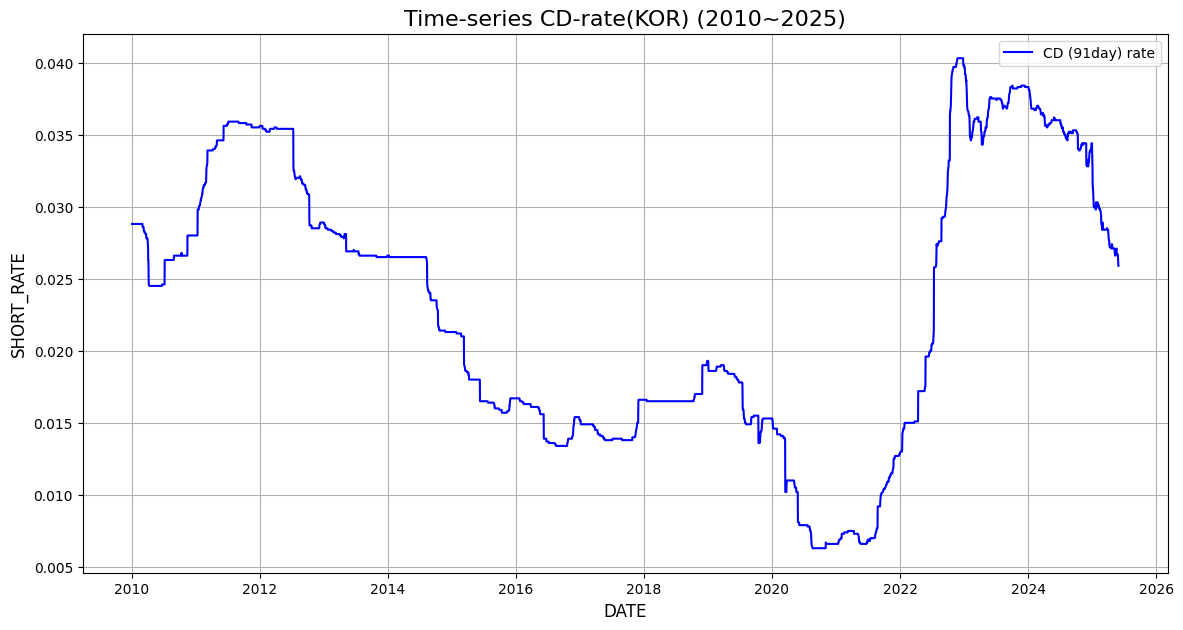

In [287]:
import matplotlib.pyplot as plt

print("\n--- Print the time series data of Short rate(CD) ---")


plt.figure(figsize=(14, 7))

plt.plot(df_CD.index, df_CD['rate'], label='CD (91day) rate', color='blue')


plt.title('Time-series CD-rate(KOR) (2010~2025)', fontsize=16)
plt.xlabel('DATE', fontsize=12)
plt.ylabel('SHORT_RATE', fontsize=12)

# 기타 옵션
plt.legend()
plt.grid(True)
plt.show()

In [288]:
start_date = df_CD.index.min()
end_date = df_CD.index.max()
print(f"Original data period: {start_date.date()} ~ {end_date.date()}")
print(f"Number of original data points: {len(df_CD)}")
print("-" * 30)

# 2. Define a new index for daily frequency
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. Reindex our data to match the new daily index.
#    This will fill missing dates (weekends/holidays) with NaN.
df_processed = df_CD.reindex(full_date_range)

# 4. Count how many missing values (NaN) were introduced due to weekends/holidays.
missing_values_count = df_processed['rate'].isnull().sum()
print(f"Number of missing dates due to weekends/holidays: {missing_values_count}")

# 5. Use forward fill to fill missing values.
#    The pandas ffill() method propagates the last valid observation forward.
df_processed['rate'].fillna(method='ffill', inplace=True)

# 6. Verify that there are no remaining missing values.
final_missing_count = df_processed['rate'].isnull().sum()
print(f"Remaining missing values after forward fill: {final_missing_count}")
print(f"Total data points after preprocessing: {len(df_processed)}")
print("-" * 30)

# 7. Print a sample to verify that preprocessing was applied correctly (including weekends).
print("--- Sample of preprocessing results (including weekend) ---")
# Check data for the last week of May 2025 (including Friday the 30th and Saturday the 31st).
print(df_processed.loc['2025-05-01':'2025-06-01'])

# Update the original DataFrame 'df_CD' with the processed data for subsequent steps.
df_CD = df_processed
print("\nPreprocessing complete. 'df_CD' has been updated with the preprocessed data.")

Original data period: 2010-01-04 ~ 2025-05-30
Number of original data points: 3811
------------------------------
Number of missing dates due to weekends/holidays: 1815
Remaining missing values after forward fill: 0
Total data points after preprocessing: 5626
------------------------------
--- Sample of preprocessing results (including weekend) ---
              rate
2025-05-01  0.0271
2025-05-02  0.0271
2025-05-03  0.0271
2025-05-04  0.0271
2025-05-05  0.0271
2025-05-06  0.0271
2025-05-07  0.0271
2025-05-08  0.0270
2025-05-09  0.0268
2025-05-10  0.0268
2025-05-11  0.0268
2025-05-12  0.0266
2025-05-13  0.0268
2025-05-14  0.0267
2025-05-15  0.0269
2025-05-16  0.0270
2025-05-17  0.0270
2025-05-18  0.0270
2025-05-19  0.0271
2025-05-20  0.0268
2025-05-21  0.0267
2025-05-22  0.0267
2025-05-23  0.0267
2025-05-24  0.0267
2025-05-25  0.0267
2025-05-26  0.0267
2025-05-27  0.0266
2025-05-28  0.0263
2025-05-29  0.0260
2025-05-30  0.0259

Preprocessing complete. 'df_CD' has been updated with the p

/tmp/ipython-input-288-4114404073.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['rate'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-288-4114404073.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_processed['rate'].fillna(method='ffill', inplace=True)


In [289]:
from scipy.optimize import minimize
import numpy as np

In [290]:
rates = df_CD['rate'].values.astype(float)
dates = df_CD.index
dt = 1/252.0  # business-day time step


In [291]:
# 1. Estimate a, sigma, theta_const by MLE under constant theta assumption
def neg_log_likelihood_const(params, r, dt):
    a, sigma, theta = params
    if a <= 0 or sigma <= 0:
        return np.inf

    exp_at = np.exp(-a * dt)
    m = r[:-1] * exp_at + theta * (1 - exp_at)
    V = (sigma**2) / (2 * a) * (1 - np.exp(-2 * a * dt))
    # negative log-likelihood
    return 0.5 * np.sum(np.log(2 * np.pi * V) + (r[1:] - m)**2 / V)

init_const = np.array([0.1, 0.01, rates.mean()])
bounds_const = [(1e-4, 10.0), (1e-4, 1.0), (None, None)]
res_const = minimize(neg_log_likelihood_const,
                     x0=init_const,
                     args=(rates, dt),
                     bounds=bounds_const,
                     method='L-BFGS-B')
a_hat, sigma_hat, theta_const = res_const.x
print(f"Step1: fitted a={a_hat:.4f}, sigma={sigma_hat:.4f}, theta_const={theta_const:.4f}")


Step1: fitted a=0.0397, sigma=0.0025, theta_const=0.0197


In [292]:
# 2. Calibrate time-dependent theta_ts from data
exp_at = np.exp(-a_hat * dt)
theta_ts = (rates[1:] - rates[:-1] * exp_at) / (1 - exp_at)
# pad to match length
theta_ts = np.concatenate(([theta_ts[0]], theta_ts))

In [293]:
# 3. Re-estimate sigma only, fixing a_hat and theta_ts
def neg_log_likelihood_sigma(s, r, dt, a, theta_ts):
    if s <= 0:
        return np.inf
    exp_at = np.exp(-a * dt)
    m = r[:-1] * exp_at + theta_ts[:-1] * (1 - exp_at)
    V = (s**2) / (2 * a) * (1 - np.exp(-2 * a * dt))
    return 0.5 * np.sum(np.log(2 * np.pi * V) + (r[1:] - m)**2 / V)

res_sigma = minimize(lambda x: neg_log_likelihood_sigma(x, rates, dt, a_hat, theta_ts),
                     x0=[sigma_hat],
                     bounds=[(1e-6, 1.0)],
                     method='L-BFGS-B')
sigma_hat = res_sigma.x[0]
print(f"Step3: re-fitted sigma={sigma_hat:.4f}")


Step3: re-fitted sigma=0.0033


In [294]:
# 4. Monte Carlo simulation with time-dependent theta
def simulate_path(r0, a, s, theta_ts, dt):
    N = len(theta_ts)
    path = np.empty(N)
    path[0] = r0
    sqrt_dt = np.sqrt(dt)
    for k in range(N-1):
        path[k+1] = (
            path[k]
            + a * (theta_ts[k] - path[k]) * dt
            + s * sqrt_dt * np.random.randn()
        )
    return path

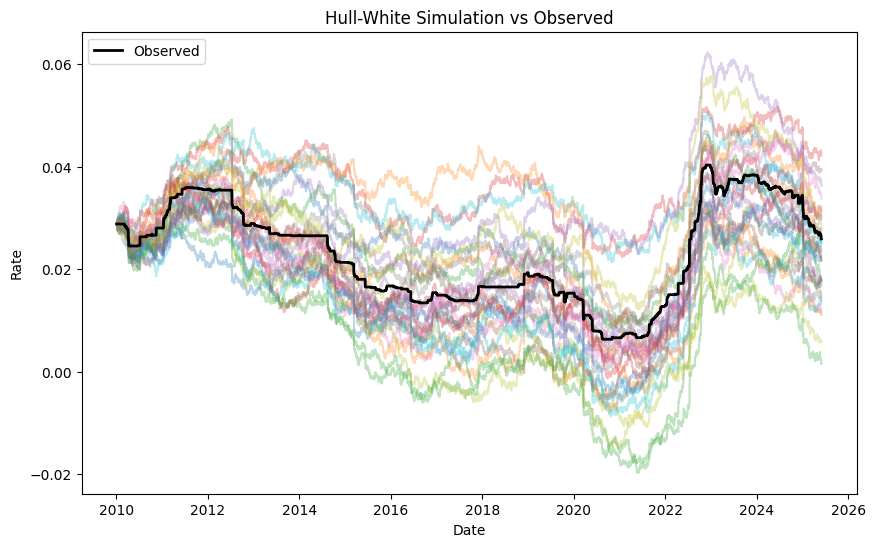

In [295]:
# simulate multiple paths
M = 30
simulations = np.vstack([
    simulate_path(rates[0], a_hat, sigma_hat, theta_ts, dt)
    for _ in range(M)
])

# plot
plt.figure(figsize=(10,6))
for i in range(M):
    plt.plot(dates, simulations[i], alpha=0.3)
plt.plot(dates, rates, color='black', lw=2, label='Observed')
plt.title('Hull-White Simulation vs Observed')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Rate')
plt.show()


In [296]:
try:
    # Send API request and convert to JSON
    response = requests.get(request_url, timeout=10)
    response.raise_for_status()
    data = response.json()

    if "StatisticSearch" in data and "row" in data["StatisticSearch"]:
        rows = data["StatisticSearch"]["row"]
        ktb_df = pd.DataFrame(rows)

        # Process the data
        ktb_df = ktb_df[['TIME', 'DATA_VALUE']]
        ktb_df.columns = ['date', 'ktb_5y_yield']  # ktb_5y_yield: 5-year KTB yield
        ktb_df['date'] = pd.to_datetime(ktb_df['date'], format='%Y%m%d')
        ktb_df['ktb_5y_yield'] = pd.to_numeric(ktb_df['ktb_5y_yield']) / 100
        ktb_df = ktb_df.set_index('date').sort_index()

        print("[Success] Successfully retrieved 5-year KTB yield data.")

        # Merge the new KTB data into the existing dataframe
        # how='left' means using the index of the original df as the base
        df = df_CD.merge(ktb_df, left_index=True, right_index=True, how='left')

        # Fill any missing KTB values using forward fill
        df['ktb_5y_yield'].fillna(method='ffill', inplace=True)
        # Fill any remaining initial NaNs using backward fill
        df['ktb_5y_yield'].fillna(method='bfill', inplace=True)

        print("Successfully merged KTB yield data into the original dataframe.")

    else:
        print(f"[API Error] ECOS returned an error message: {data.get('RESULT', {}).get('MESSAGE', 'Unknown error')}")

except Exception as e:
    print(f"[Error] An issue occurred while processing KTB data: {e}")

[Success] Successfully retrieved 5-year KTB yield data.
Successfully merged KTB yield data into the original dataframe.


/tmp/ipython-input-296-2855864513.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ktb_5y_yield'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-296-2855864513.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ktb_5y_yield'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-296-2855864513.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an in

In [297]:
print(df.tail())

              rate  ktb_5y_yield
2025-05-26  0.0267        0.0267
2025-05-27  0.0266        0.0266
2025-05-28  0.0263        0.0263
2025-05-29  0.0260        0.0260
2025-05-30  0.0259        0.0259


In [298]:
a_hat = 0.0397
sigma_hat = 0.0033
theta_const = 0.0197
face_value_ktb = 100  # Face value

# --- Hull-White analytical pricing functions ---

def B_hull_white(T_minus_t, a):
    """ Compute the B(t, T) function """
    if a == 0:
        return T_minus_t
    return (1 - np.exp(-a * T_minus_t)) / a

def A_hull_white(T_minus_t, a, sigma, theta):
    """ Compute the A(t, T) function (assuming constant theta) """
    if a == 0:
        # Special case when a = 0 (similar to Vasicek model)
        return np.exp((theta - 0.5 * sigma**2) * T_minus_t - 0.5 * sigma**2 * T_minus_t**2)

    b_val = B_hull_white(T_minus_t, a)

    # Compute ln(A(t, T))
    term1 = (theta - (sigma**2) / (2 * a**2)) * (b_val - T_minus_t)
    term2 = (sigma**2) / (4 * a) * (b_val**2)

    ln_A = term1 - term2
    return np.exp(ln_A)

def price_bond_hull_white(r_t, T_minus_t, a, sigma, theta):
    """
    Compute the theoretical bond price using the analytical solution of the Hull-White model.

    Args:
        r_t (float): current short rate
        T_minus_t (float): time to maturity (in years)
        a (float): mean-reversion speed
        sigma (float): volatility
        theta (float): long-term mean rate (assumed constant)

    Returns:
        float: theoretical bond price
    """
    if T_minus_t <= 0:
        return face_value_ktb

    A = A_hull_white(T_minus_t, a, sigma, theta)
    B = B_hull_white(T_minus_t, a)

    price = A * np.exp(-B * r_t)

    return price * face_value_ktb


In [299]:
maturity_ktb = 5  # 5-year maturity KTB

# Apply the price_bond_hull_white function to each row in the DataFrame.
# r_t: CD rate on each date (rate_cd)
# T_minus_t: Time remaining to maturity (fixed to 5 years)
df['theoretical_price_5y'] = df.apply(
    lambda row: price_bond_hull_white(
        r_t=row['rate'],
        T_minus_t=maturity_ktb,
        a=a_hat,
        sigma=sigma_hat,
        theta=theta_const
    ),
    axis=1
)

print("--- Final DataFrame with Theoretical Bond Prices ---")
print(df.head())
print(df.tail())


--- Final DataFrame with Theoretical Bond Prices ---
              rate  ktb_5y_yield  theoretical_price_5y
2010-01-04  0.0288        0.0288             86.972984
2010-01-05  0.0288        0.0288             86.972984
2010-01-06  0.0288        0.0288             86.972984
2010-01-07  0.0288        0.0288             86.972984
2010-01-08  0.0288        0.0288             86.972984
              rate  ktb_5y_yield  theoretical_price_5y
2025-05-26  0.0267        0.0267             87.805231
2025-05-27  0.0266        0.0266             87.845060
2025-05-28  0.0263        0.0263             87.964655
2025-05-29  0.0260        0.0260             88.084413
2025-05-30  0.0259        0.0259             88.124368


In [300]:
df['actual_price_5y'] = face_value_ktb / ((1 + df['ktb_5y_yield'])**maturity_ktb)
df['price_error_5y'] = df['actual_price_5y'] - df['theoretical_price_5y']

In [301]:
print(df.tail())

              rate  ktb_5y_yield  theoretical_price_5y  actual_price_5y  \
2025-05-26  0.0267        0.0267             87.805231        87.656109   
2025-05-27  0.0266        0.0266             87.845060        87.698810   
2025-05-28  0.0263        0.0263             87.964655        87.827062   
2025-05-29  0.0260        0.0260             88.084413        87.955539   
2025-05-30  0.0259        0.0259             88.124368        87.998415   

            price_error_5y  
2025-05-26       -0.149122  
2025-05-27       -0.146250  
2025-05-28       -0.137593  
2025-05-29       -0.128873  
2025-05-30       -0.125953  


In [346]:



# input(X): feature , answer(Y):target_col


features = ['rate', 'ktb_5y_yield', 'theoretical_price_5y', 'actual_price_5y', 'price_error_5y']
target_col = 'price_error_5y'


df['price_change'] = df[target_col].diff().shift(-1)

train_df = df.loc['2010-01-01':'2023-12-31']
test_df = df.loc['2024-01-01':'2025-05-30']




X_train = train_df[features]
y_train = train_df[target_col].shift(-1)  # To predict the tomorrow's error

X_test = test_df[features]
y_test = test_df[target_col].shift(-1)  # Tomorrow's


# because of shift(-1) the last data is NaN so eliminate it
X_train = X_train[:-1]
y_train = y_train[:-1]
X_test = X_test[:-1]
y_test = y_test[:-1]

In [347]:
print(X_train.tail())

              rate  ktb_5y_yield  theoretical_price_5y  actual_price_5y  \
2023-12-26  0.0383        0.0383             83.305524        82.867785   
2023-12-27  0.0383        0.0383             83.305524        82.867785   
2023-12-28  0.0383        0.0383             83.305524        82.867785   
2023-12-29  0.0383        0.0383             83.305524        82.867785   
2023-12-30  0.0383        0.0383             83.305524        82.867785   

            price_error_5y  
2023-12-26       -0.437739  
2023-12-27       -0.437739  
2023-12-28       -0.437739  
2023-12-29       -0.437739  
2023-12-30       -0.437739  


In [348]:
print(X_test.tail())

              rate  ktb_5y_yield  theoretical_price_5y  actual_price_5y  \
2025-05-25  0.0267        0.0267             87.805231        87.656109   
2025-05-26  0.0267        0.0267             87.805231        87.656109   
2025-05-27  0.0266        0.0266             87.845060        87.698810   
2025-05-28  0.0263        0.0263             87.964655        87.827062   
2025-05-29  0.0260        0.0260             88.084413        87.955539   

            price_error_5y  
2025-05-25       -0.149122  
2025-05-26       -0.149122  
2025-05-27       -0.146250  
2025-05-28       -0.137593  
2025-05-29       -0.128873  


In [349]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y_error = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y_error.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)

In [350]:
pip install lightgbm

In [351]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

print('Grid Search (Hyperparameter Tuning) start')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 40, 100],
}

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit model to training data
grid_search.fit(X_train_scaled, y_train_scaled.ravel())

print('Grid Search (Hyperparameter Tuning) end')
print(f"The best parameters found: {grid_search.best_params_}")

# Use the best estimator for final prediction
final_error_model = grid_search.best_estimator_

# Predict the scaled error
predicted_error_scaled = final_error_model.predict(X_test_scaled)

# Inverse transform to get the actual error
predicted_error = scaler_y_error.inverse_transform(predicted_error_scaled.reshape(-1, 1))

# Reconstruct bond price using theoretical + predicted error
theoretical_price_test = X_test['theoretical_price_5y'].values
y_pred_reconstructed = theoretical_price_test + predicted_error.flatten()

# Actual prices for evaluation
y_test_actual_price = X_test['actual_price_5y'].values

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual_price, y_pred_reconstructed))
mape = np.mean(np.abs((y_test_actual_price - y_pred_reconstructed) / y_test_actual_price)) * 100

print("\n--- Final Evaluation of the Tuned Error Prediction Model ---")
print(f"  - RMSE: {rmse:.2f} KRW")
print(f"  - MAPE: {mape:.2f} %")


Grid Search (Hyperparameter Tuning) start
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 5109, number of used features: 5
[LightGBM] [Info] Start training from score 0.474001
Grid Search (Hyperparameter Tuning) end
The best parameters found: {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 31}

--- Final Evaluation of the Tuned Error Prediction Model ---
  - RMSE: 0.00 KRW
  - MAPE: 0.00 %


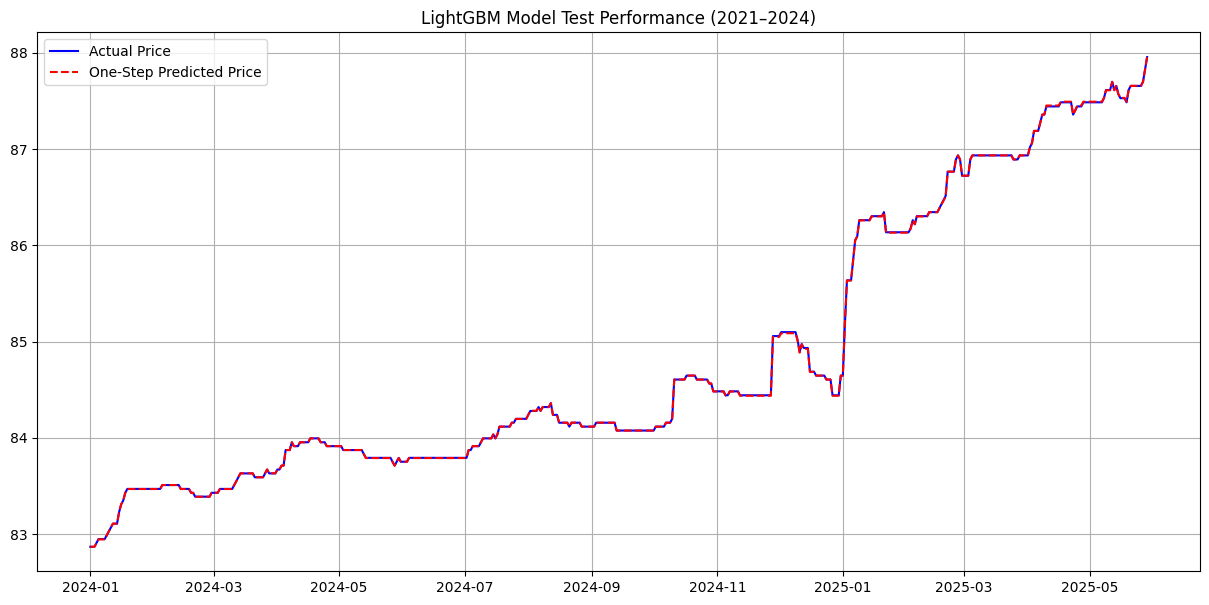

In [352]:
one_step_predicted_error_scaled = final_error_model.predict(X_test_scaled)
one_step_predicted_error = scaler_y_error.inverse_transform(one_step_predicted_error_scaled.reshape(-1, 1))

# 2. Reconstruct the final bond price prediction
theoretical_price_test = X_test['theoretical_price_5y'].values
one_step_reconstructed_price = theoretical_price_test + one_step_predicted_error.flatten()

# 3. Visualize the reconstructed price compared to actual price
y_test_actual_price = X_test['actual_price_5y'].values

plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test_actual_price, label='Actual Price', color='blue')
plt.plot(X_test.index, one_step_reconstructed_price, label='One-Step Predicted Price', color='red', linestyle='--')
plt.title("LightGBM Model Test Performance (2021–2024)")
plt.legend()
plt.grid(True)
plt.show()


In [353]:
seed_date = '2024-12-31'
forecast_start_date = '2025-01-01'
forecast_end_date = '2025-12-31'

# Feature values on the seed date used as the starting point for prediction
last_known_features = df.loc[seed_date][features].values.reshape(1, -1)

# Date range for the prediction period
future_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
prediction_days = len(future_dates)


In [354]:
dt = 1/255
a_hat = 0.0397
sigma_hat = 0.0033
theta_const = 0.0197
current_rate = df.loc[seed_date, 'rate']
current_spread = df.loc[seed_date, 'ktb_5y_yield'] - current_rate

future_rates, future_ktb_yields = [], []

for _ in range(prediction_days):
    random_shock = np.random.normal(0, 1)
    drift = a_hat * (theta_const - current_rate) * dt
    diffusion = sigma_hat * np.sqrt(dt) * random_shock
    current_rate += drift + diffusion
    future_rates.append(current_rate)
    future_ktb_yields.append(current_rate + current_spread)

future_sim_df = pd.DataFrame(data={'rate': future_rates, 'ktb_5y_yield': future_ktb_yields}, index=future_dates)


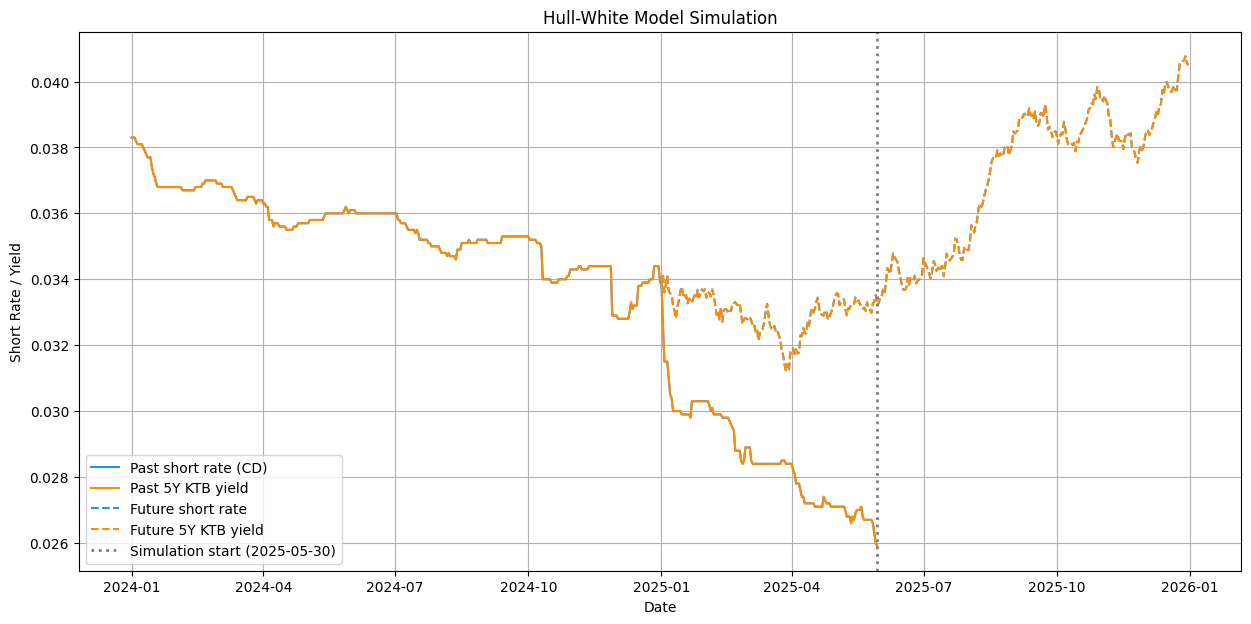

In [355]:
plt.figure(figsize=(15, 7))

# 1. Plot historical data (from 2024) as solid lines.
plt.plot(df.loc['2024':, 'rate'], label='Past short rate (CD)', color='dodgerblue')
plt.plot(df.loc['2024':, 'ktb_5y_yield'], label='Past 5Y KTB yield', color='darkorange')

# 2. Plot simulated future data as dashed lines.
plt.plot(future_sim_df['rate'], label='Future short rate', color='dodgerblue', linestyle='--')
plt.plot(future_sim_df['ktb_5y_yield'], label='Future 5Y KTB yield', color='darkorange', linestyle='--')

# 3. Mark the starting point of the simulation with a vertical dashed gray line.
plt.axvline(df.index[-1], color='gray', linestyle=':', linewidth=2, label=f'Simulation start ({df.index[-1].date()})')

# 4. Set graph title, axis labels, and other display settings.
plt.title("Hull-White Model Simulation")
plt.xlabel("Date")
plt.ylabel("Short Rate / Yield")
plt.legend()
plt.grid(True)
plt.show()


In [356]:
print(df.tail())

              rate  ktb_5y_yield  theoretical_price_5y  actual_price_5y  \
2025-05-26  0.0267        0.0267             87.805231        87.656109   
2025-05-27  0.0266        0.0266             87.845060        87.698810   
2025-05-28  0.0263        0.0263             87.964655        87.827062   
2025-05-29  0.0260        0.0260             88.084413        87.955539   
2025-05-30  0.0259        0.0259             88.124368        87.998415   

            price_error_5y  price_change  
2025-05-26       -0.149122      0.002872  
2025-05-27       -0.146250      0.008657  
2025-05-28       -0.137593      0.008719  
2025-05-29       -0.128873      0.002920  
2025-05-30       -0.125953           NaN  


In [357]:
print(future_sim_df.tail())

                rate  ktb_5y_yield
2025-12-27  0.040623      0.040623
2025-12-28  0.040645      0.040645
2025-12-29  0.040768      0.040768
2025-12-30  0.040553      0.040553
2025-12-31  0.040497      0.040497


                   a     sigma
2025-05-26  0.107507  0.001959
2025-05-27  0.105594  0.001959
2025-05-28  0.108766  0.001876
2025-05-29  0.105235  0.001923
2025-05-30  0.104673  0.001928


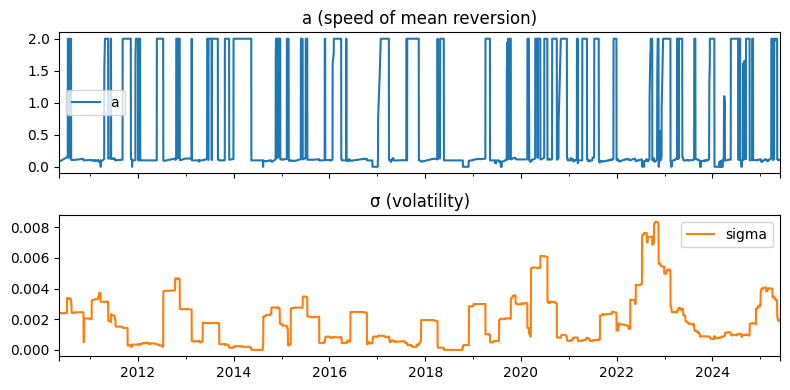

In [358]:
rates_ts = df['rate'].sort_index()
dt = 1/252  # Daily interval (business days)

# ── 2. Define negative log-likelihood function ──
def neg_log_likelihood(params, sample, dt):
    a, sigma = params
    diffs = np.diff(sample)
    rt = sample[:-1]
    theta = np.mean(sample)               # Assume θ as average rate in the window
    mu = a * (theta - rt) * dt
    var = sigma**2 * dt
    # Log-likelihood under normal distribution (Euler–Maruyama approximation)
    ll = -0.5 * np.sum((diffs - mu)**2 / var + np.log(2 * np.pi * var))
    return -ll

# ── 3. Rolling window MLE estimation ──
window = 126   # Approx. 6 months (126 trading days)
a_hist, sigma_hist, hist_dates = [], [], []

for i in range(window, len(rates_ts)):
    sample = rates_ts.iloc[i-window:i+1].to_numpy()
    res = minimize(
        neg_log_likelihood,
        x0=[0.1, 0.01],
        args=(sample, dt),
        bounds=[(1e-4, 2.0), (1e-6, 0.5)]
    )
    a_hist.append(res.x[0])
    sigma_hist.append(res.x[1])
    hist_dates.append(rates_ts.index[i])

# ── 4. Organize results and visualize ──
param_df = pd.DataFrame({
    'a': a_hist,
    'sigma': sigma_hist
}, index=hist_dates)

# Display the last few estimated parameters
print(param_df.tail())

# Plot the estimated parameters
param_df.plot(subplots=True, figsize=(8,4), title=['a (speed of mean reversion)', 'σ (volatility)'])
plt.tight_layout()
plt.show()


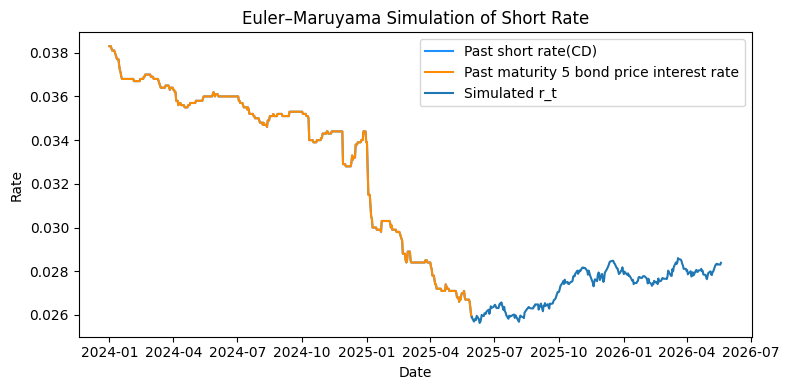

In [359]:
start_date = df.index[-1]
r0 = df['rate'].iloc[-1]

# 최신 추정된 a, sigma
a = param_df['a'].iloc[-1]
sigma = param_df['sigma'].iloc[-1]

# 시뮬레이션 설정
T = 1.0             # 예측 기간(년)
dt = 1/252          # 일 단위(영업일)
n_steps = int(T / dt)
times = np.linspace(0, T, n_steps+1)

# θ(t)를 최근 윈도우 평균으로 고정하거나, 필요시 포워드 커브를 사용
theta_const = df['rate'].iloc[-126:].mean()
theta = np.full(n_steps, theta_const)

# ── 2. Euler–Maruyama 시뮬레이션 ──
rates_sim = np.zeros(n_steps+1)
rates_sim[0] = r0

for k in range(n_steps):
    dw = np.random.normal(scale=np.sqrt(dt))
    rates_sim[k+1] = rates_sim[k] + a * (theta[k] - rates_sim[k]) * dt + sigma * dw

# 3) 할당 확인
# ── 3. 결과 시각화 ──

plt.figure(figsize=(8,4))
plt.plot(df.loc['2024':, 'rate'], label='Past short rate(CD)', color='dodgerblue')
plt.plot(df.loc['2024':, 'ktb_5y_yield'], label='Past maturity 5 bond price interest rate', color='darkorange')

plt.plot(pd.date_range(start=start_date, periods=n_steps+1, freq='B'),
         rates_sim, label='Simulated r_t')
plt.title("Euler–Maruyama Simulation of Short Rate")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.tight_layout()
plt.show()

In [360]:
a_hat = 0.104673
sigma_hat = 0.001928
theta_const = 0.0326  # Set theta as the average of the past 6 months for forecasting

# LightGBM final model (defined using user-tuned hyperparameters)
final_error_model = lgb.LGBMRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    num_leaves=31,
    random_state=42
)

# Scalers used during training (for X and y)
# These need to be refit unless previously saved, so we temporarily fit them again using past data
df_for_scaler = df.loc['2010-01-01':'2023-12-31'].copy()
X_train_scaler_data = df_for_scaler[features][:-1]
y_train_scaler_data = df_for_scaler[target_col].shift(-1)[:-1]

scaler_X = MinMaxScaler().fit(X_train_scaler_data)
scaler_y_error = MinMaxScaler().fit(y_train_scaler_data.values.reshape(-1, 1))

# Retrain model with scaled training data (bypassing GridSearchCV for speed)
X_train_scaled = scaler_X.transform(X_train_scaler_data)
y_train_scaled = scaler_y_error.transform(y_train_scaler_data.values.reshape(-1, 1))
final_error_model.fit(X_train_scaled, y_train_scaled.ravel())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 5109, number of used features: 5
[LightGBM] [Info] Start training from score 0.474001


LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=42)

In [361]:
seed_date = '2025-05-30'
forecast_start_date = '2025-06-01'
forecast_end_date = '2026-12-31'
future_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')  # Business days
prediction_days = len(future_dates)
dt = 1/252  # Daily step (business days)

# Initialize with current observed rate and spread
current_rate = df.loc[seed_date, 'rate']
current_spread = df.loc[seed_date, 'ktb_5y_yield'] - current_rate

future_rates, future_ktb_yields = [], []
np.random.seed(42)  # Set seed for reproducibility

for _ in range(prediction_days):
    dw = np.random.normal(scale=np.sqrt(dt))  # Brownian motion increment
    drift = a_hat * (theta_const - current_rate) * dt
    diffusion = sigma_hat * dw
    current_rate += drift + diffusion
    future_rates.append(current_rate)
    future_ktb_yields.append(current_rate + current_spread)

# Create DataFrame of simulated future rates and 5Y KTB yields
future_sim_df = pd.DataFrame(
    data={'rate': future_rates, 'ktb_5y_yield': future_ktb_yields},
    index=future_dates
)



--- Forecasted 5Y KTB Prices for 2025 ---
            Forecasted_Price
2025-06-02         87.061686
2025-06-03         87.043980
2025-06-04         87.016346
2025-06-05         86.952678
2025-06-06         86.961422


            Forecasted_Price
2026-12-25         86.381502
2026-12-28         86.351709
2026-12-29         86.389627
2026-12-30         86.459220
2026-12-31         86.407820


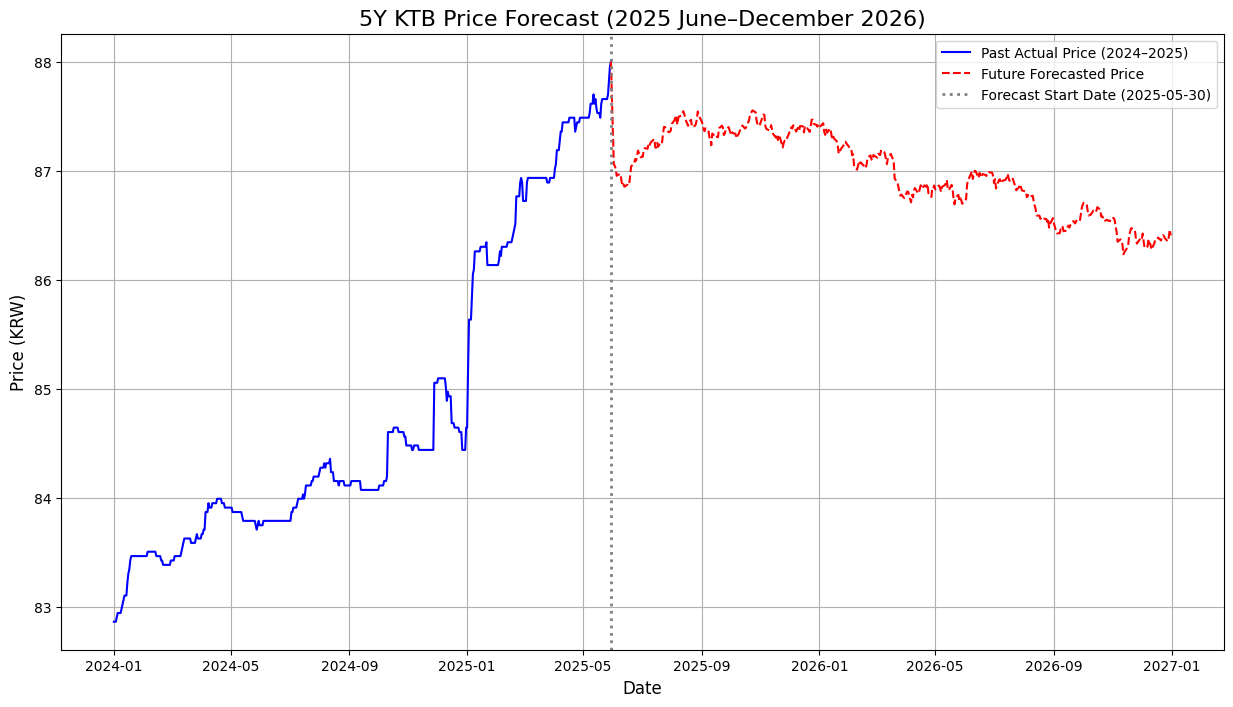

In [362]:
future_predicted_prices = []
current_features = df.loc[seed_date][features].values.reshape(1, -1)  # Starting point for prediction

for date in future_dates:
    # 1. Predict today's (t) error using current features (t-1)
    current_features_scaled = scaler_X.transform(current_features)
    predicted_error_scaled = final_error_model.predict(current_features_scaled)
    predicted_error = scaler_y_error.inverse_transform(predicted_error_scaled.reshape(-1, 1))[0][0]

    # 2. Get today's (t) simulated short rate and KTB yield
    sim_rate = future_sim_df.loc[date]['rate']
    sim_ktb_yield = future_sim_df.loc[date]['ktb_5y_yield']

    # 3. Compute today's (t) theoretical bond price
    theoretical_price = price_bond_hull_white(sim_rate, 5, a_hat, sigma_hat, theta_const)

    # 4. Final predicted price = theoretical price + predicted error
    final_predicted_price = theoretical_price + predicted_error
    future_predicted_prices.append(final_predicted_price)

    # 5. Update features for tomorrow's (t+1) prediction
    actual_price_proxy = face_value_ktb / ((1 + sim_ktb_yield)**5)
    current_features = np.array([[sim_rate, sim_ktb_yield, theoretical_price, actual_price_proxy, predicted_error]])

# Create forecast DataFrame
df_forecast = pd.DataFrame({'Forecasted_Price': future_predicted_prices}, index=future_dates)

print("\n--- Forecasted 5Y KTB Prices for 2025 ---")
print(df_forecast.head())
print("\n")
print(df_forecast.tail())

# --- 4. Visualization of Final Result ---
last_actual_price = pd.Series([df.loc[seed_date, 'actual_price_5y']], index=[pd.to_datetime(seed_date)])
df_forecast_visual = pd.concat([last_actual_price.rename('Forecasted_Price'), df_forecast['Forecasted_Price']])

# Plot
plt.figure(figsize=(15, 8))

# Past actual price
plt.plot(df.loc['2024':, 'actual_price_5y'], label='Past Actual Price (2024–2025)', color='blue')

# Future predicted price (linked from last actual price)
plt.plot(df_forecast_visual, label='Future Forecasted Price', color='red', linestyle='--')

plt.axvline(x=pd.to_datetime(seed_date), color='gray', linestyle=':', linewidth=2, label=f'Forecast Start Date ({seed_date})')
plt.title("5Y KTB Price Forecast (2025 June–December 2026)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (KRW)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Starting backtesting...
Backtesting completed!

--- Backtesting Results ---
Initial Capital: 10,000 KRW
Final Portfolio Value: 10,796 KRW
Model Strategy Total Return: 7.96%
Buy and Hold Total Return: 5.98%


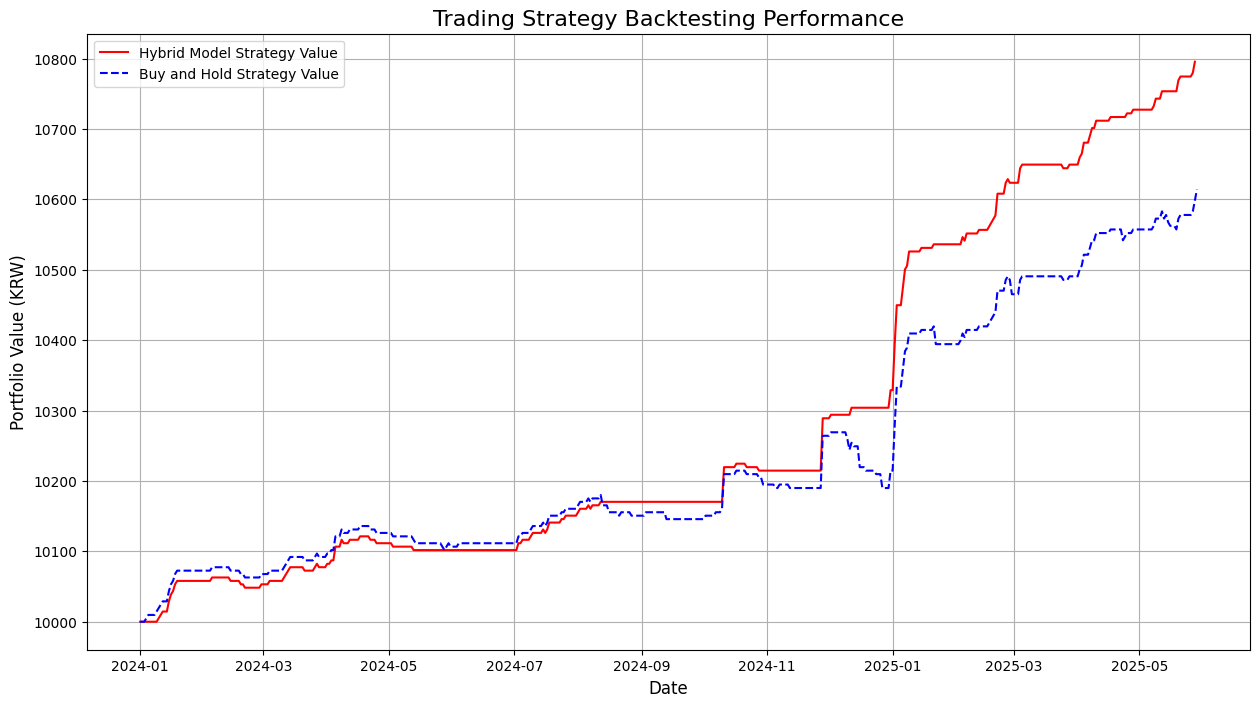

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Backtesting Environment Setup ---

# Use actual and predicted prices over the test period
backtest_df = pd.DataFrame({
    'actual_price': y_test_actual_price,
    'predicted_price': y_pred_reconstructed
}, index=X_test.index)

# Backtesting parameters
initial_cash = 10000  # Initial capital (KRW)
trade_threshold = 0.0005  # Trade only if predicted price change exceeds 0.05%

# Initialize portfolio state variables
cash = initial_cash
position = 'OUT'  # 'IN' = holding bond, 'OUT' = holding cash
holdings = 0      # Number of bonds held
portfolio_history = []  # Daily portfolio value history

# --- 2. Run Backtesting Loop ---

print("Starting backtesting...")

for i in range(len(backtest_df) - 1):
    actual_price_today = backtest_df['actual_price'].iloc[i]
    predicted_price_tomorrow = backtest_df['predicted_price'].iloc[i + 1]

    # If not holding bonds (cash only)
    if position == 'OUT':
        if predicted_price_tomorrow > actual_price_today * (1 + trade_threshold):
            holdings = cash / actual_price_today
            cash = 0
            position = 'IN'

    # If holding bonds
    elif position == 'IN':
        if predicted_price_tomorrow < actual_price_today * (1 - trade_threshold):
            cash = holdings * actual_price_today
            holdings = 0
            position = 'OUT'

    # Record current portfolio value
    current_portfolio_value = cash + holdings * actual_price_today
    portfolio_history.append(current_portfolio_value)

print("Backtesting completed!")
backtest_df['portfolio_value'] = pd.Series(portfolio_history, index=backtest_df.index[:-1])

# --- 3. Performance Evaluation ---

# 1. Final portfolio value and return
final_value = portfolio_history[-1]
total_return = (final_value - initial_cash) / initial_cash * 100

# 2. Benchmark: Buy and Hold strategy
daily_returns = backtest_df['actual_price'].pct_change().fillna(0)
cumulative_returns = (1 + daily_returns).cumprod()
backtest_df['buy_and_hold'] = initial_cash * cumulative_returns
buy_and_hold_final_value = backtest_df['buy_and_hold'].iloc[-2]
buy_and_hold_return = (buy_and_hold_final_value - initial_cash) / initial_cash * 100

print("\n--- Backtesting Results ---")
print(f"Initial Capital: {initial_cash:,.0f} KRW")
print(f"Final Portfolio Value: {final_value:,.0f} KRW")
print(f"Model Strategy Total Return: {total_return:.2f}%")
print(f"Buy and Hold Total Return: {buy_and_hold_return:.2f}%")

# --- 4. Visualization ---
plt.figure(figsize=(15, 8))
plt.plot(backtest_df['portfolio_value'], label='Hybrid Model Strategy Value', color='red')
plt.plot(backtest_df['buy_and_hold'], label='Buy and Hold Strategy Value', color='blue', linestyle='--')

plt.title("Trading Strategy Backtesting Performance", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (KRW)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Prepare Data for Simulation ---
# Assumes previous definitions: backtest_df and forecast_df

# --- 2. Initialize Portfolio State and Parameters ---
initial_cash = 10000
trade_threshold = 0.0005
cash = initial_cash
position = 'OUT'
holdings = 0
total_portfolio_history = []  # Store both past and future portfolio values


In [370]:
# --- 3. Run Backtest (Historical Performance Evaluation) ---
print("Starting backtest (historical performance)...")
for i in range(len(backtest_df) - 1):
    actual_price_today = backtest_df['actual_price'].iloc[i]
    predicted_price_tomorrow = backtest_df['predicted_price'].iloc[i + 1]

    if position == 'OUT':
        if predicted_price_tomorrow > actual_price_today * (1 + trade_threshold):
            holdings = cash / actual_price_today
            cash = 0
            position = 'IN'
    elif position == 'IN':
        if predicted_price_tomorrow < actual_price_today * (1 - trade_threshold):
            cash = holdings * actual_price_today
            holdings = 0
            position = 'OUT'

    current_portfolio_value = cash + holdings * actual_price_today
    total_portfolio_history.append(current_portfolio_value)
print("Backtest completed!")


Starting backtest (historical performance)...
Backtest completed!


In [371]:
# --- 4. Run Future Forecast Simulation (Continuation) ---
# Carry over final state from backtest

last_backtest_price = backtest_df['actual_price'].iloc[-1]
last_portfolio_value = cash + holdings * last_backtest_price
total_portfolio_history.append(last_portfolio_value)

print("\nStarting future forecast simulation...")
for i in range(len(forecast_df) - 1):
    price_today = forecast_df['Forecasted_Price'].iloc[i]
    predicted_price_tomorrow = forecast_df['Forecasted_Price'].iloc[i + 1]

    if position == 'OUT':
        if predicted_price_tomorrow > price_today * (1 + trade_threshold):
            holdings = cash / price_today
            cash = 0
            position = 'IN'
    elif position == 'IN':
        if predicted_price_tomorrow < price_today * (1 - trade_threshold):
            cash = holdings * price_today
            holdings = 0
            position = 'OUT'

    current_portfolio_value = cash + holdings * price_today
    total_portfolio_history.append(current_portfolio_value)
print("Forecast simulation completed!")


Starting future forecast simulation...
Forecast simulation completed!


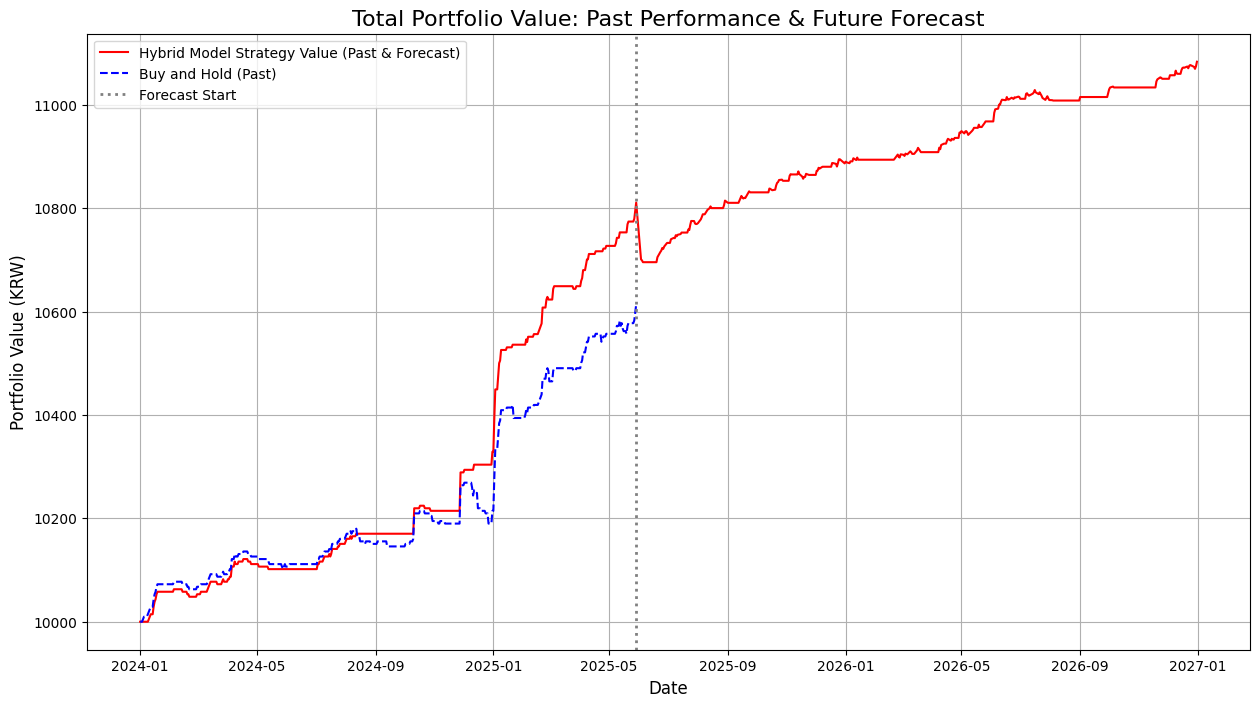

In [372]:
# --- 5. Final Visualization (Combined) ---

# Combine past and future date indices
combined_index = backtest_df.index.append(forecast_df.index[1:])

# Create a Series with total portfolio value
combined_performance = pd.Series(total_portfolio_history, index=combined_index)

# Benchmark: Buy and Hold strategy over historical period only
buy_and_hold_value = initial_cash * (1 + backtest_df['actual_price'].pct_change().fillna(0)).cumprod()

# --- Plot ---
plt.figure(figsize=(15, 8))

plt.plot(combined_performance, label='Hybrid Model Strategy Value (Past & Forecast)', color='red')
plt.plot(buy_and_hold_value, label='Buy and Hold (Past)', color='blue', linestyle='--')

# Mark the forecast start date
plt.axvline(x=backtest_df.index[-1], color='gray', linestyle=':', linewidth=2, label='Forecast Start')

plt.title("Total Portfolio Value: Past Performance & Future Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (KRW)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
